## 1日の中で時間ごとの歩数の遷移をモデル化する

In [98]:
%matplotlib inline
import random
import numpy
import matplotlib.pylab as plt

### 杉山先生がランダム9人の10日間の歩数を時間ごとに出してはった

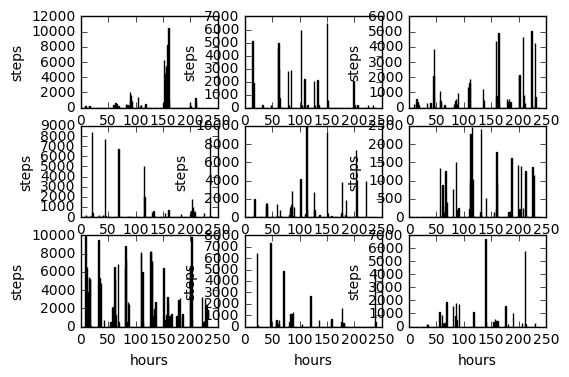

In [82]:
f = open('datasets.npz', 'rb')
dataset = numpy.load(f)
X = dataset['all']

f, axes = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        datasets = X[random.randint(0, X.shape[0] - 1)]
        # print 'dataset: ', dataset
        axes[i][j].bar(xrange(240), datasets)
        axes[i][j].set_xlabel('hours')
        axes[i][j].set_ylabel('steps')
plt.show()

### 10日の中で1時間ごとの歩数のヒストグラムを作成

In [266]:
#print X.shape
daily_steps = X
#print daily_step.shape
daily_step = daily_steps[daily_steps != 0.0]
#daily_steps.reshape(-1,)
#numpy.ravel(daily_steps)
#print daily_steps.shape

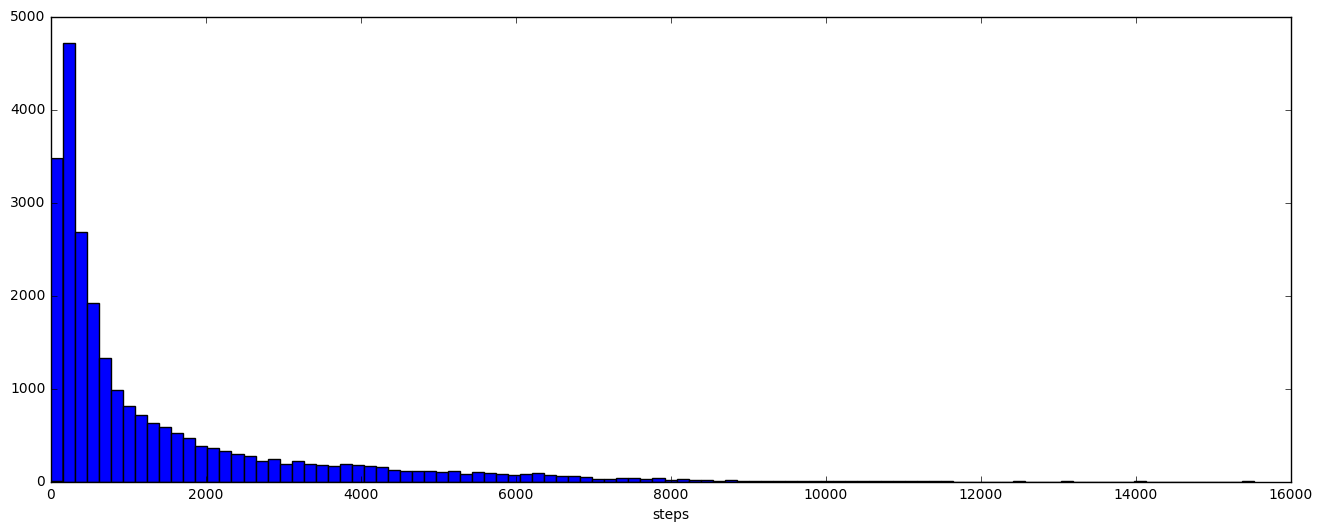

In [267]:
plt.figure(figsize=(16,6))
plt.hist(daily_step, bins=100)
plt.xlabel('steps')
#plt.xticks([156, 495, 1008, 1717, 2742, 4030, 5609, 8166])
plt.show()

In [268]:
print numpy.max(daily_step)

15520.7


### 歩数を人の状態として捉えるためにK-meansでクラスタリング

In [269]:
import scipy.cluster

#daily_step_1d = daily_step.reshape((-1, ))
#print daily_step_1d.shape
#とりあえずk=8でやる
codebook, destortion = scipy.cluster.vq.kmeans(daily_step, 8)
#ちなみに16クラスタ、32クラスタでもクラスタリング可能っぽい
#codebook, destortion = scipy.cluster.vq.kmeans(daily_step_1d, 8)
codebook = numpy.sort(codebook)
print codebook

#code, dist = scipy.cluster.vq.vq(daily_step_1d, codebook)
#print code, dist

[  181.19004822   554.90136719  1082.95385742  1745.42126465  2659.33032227
  3935.85424805  5694.328125    8223.57128906]


In [270]:
import collections

code, dist = scipy.cluster.vq.vq(daily_step, codebook)
print collections.Counter(code)

Counter({0: 9359, 1: 5040, 2: 2932, 3: 2315, 4: 1751, 5: 1519, 6: 1156, 7: 405})


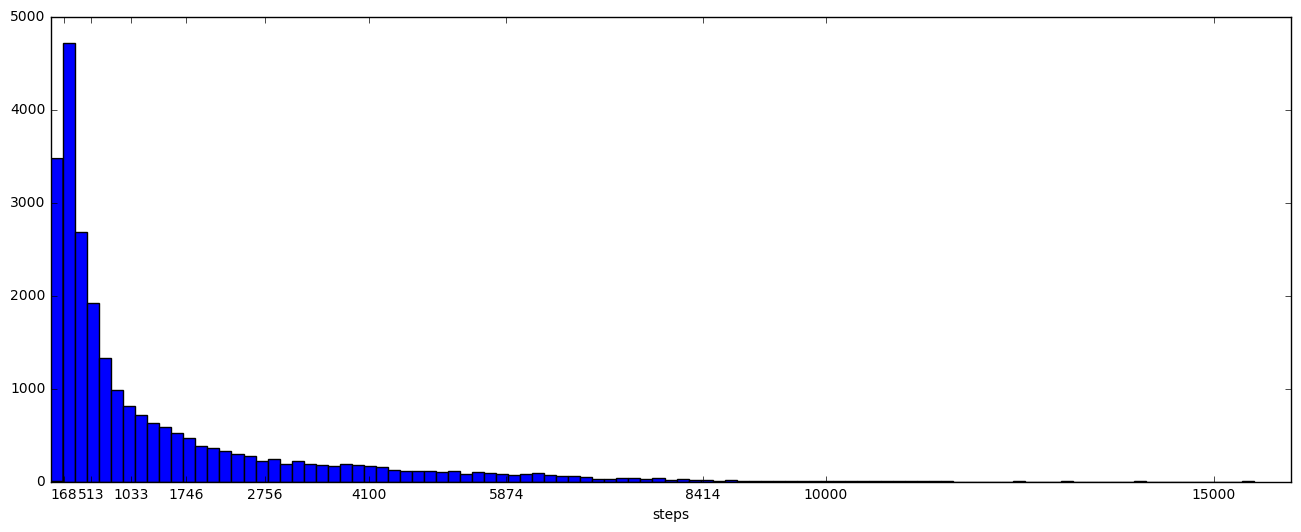

In [272]:
plt.figure(figsize=(16,6))
plt.hist(daily_step, bins=100)
plt.xlabel('steps')
plt.xticks([168, 513, 1033, 1746, 2756, 4100, 5874, 8414, 10000, 15000])
plt.show()

### 1日8000歩達成した人と未完の人を分けて１日のクラスタ遷移を見る
使ってない(7/7現在)

In [227]:
#まず1日8000歩達成した人としていない人を分けよう
kampo_daily = numpy.zeros((0, 24))
mikan_daily = numpy.zeros((0, 24))

for step in daily_step:
    if numpy.sum(step) >= 8000:
        kampo_daily = numpy.vstack((kampo_daily, step))
        
    else:
        mikan_daily = numpy.vstack((mikan_daily, step))

(142, 24)
(562, 24)


In [238]:
kampo_tra = numpy.zeros((0, 24))
mikan_tra = numpy.zeros((0, 24))

#1日8000歩以上歩いた人
for name in kampo_daily:
    code, dist = scipy.cluster.vq.vq(name, codebook)
    kampo_tra = numpy.vstack((kampo_tra, code))
    
for name in mikan_daily:
    code, dist = scipy.cluster.vq.vq(name, codebook)
    mikan_tra = numpy.vstack((mikan_tra, code))
    
print "kampo user: "
for i in range(3):
    print kampo_tra[random.randint(0, kampo_tra.shape[0] - 1)]

print "mikan user: "
for i in range(3):
    print mikan_tra[random.randint(0, mikan_tra.shape[0] - 1)]

kampo user: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  7.  1.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  3.  0.  0.  0.  6.
  0.  0.  5.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  6.  6.  1.  0.  0.]
mikan user: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.]


### 10日間の中で遷移パターンに落とし込む

In [287]:
# まずは10日の1時間ごとのデータを24時間ごとに分割
test_ary = daily_steps
#print test_ary.shape[0]
test_ary = test_ary.reshape((-1, 24))
print daily_steps.shape
print test_ary.shape

(704, 240)
(7040, 24)


In [292]:
# 24時間ごとのデータに対して遷移パターンを作成
daily_trans = numpy.zeros((0, 24))

for name in test_ary:
    code, dist = scipy.cluster.vq.vq(name, codebook)
    daily_trans = numpy.vstack((daily_trans, code))
    
print daily_trans.shape
#print test_ary[1]
#print daily_trans[1]

(7040, 24)


In [306]:
# 配列の要素の編集距離を出力する関数
def ary_leven(ary1, ary2):
    result = 0
    
    for i, j in zip(ary1, ary2):
        if i == j: continue
        result += 1
            
    return result

In [311]:
# 遷移パターンをクラスタリング
# とりあえずward法、距離は文章の近さなどを調べるときの編集距離を使用する

# 遷移パターンの編集距離を出力する

import Levenshtein

pattern_dist = []
for num1, pattern1 in enumerate(daily_trans):
    for num2, pattern2 in enumerate(daily_trans):
        if num1 == num2: continue
        #str1, str2 = map(str, pattern1), map(str, pattern2)
        #str1, str2 = ",".join(str1), ",".join(str2)
        #pattern_dist.append(Levenshtein.distance(str1, str2))
        pattern_dist.append(ary_leven(pattern1, pattern2))
        
print pattern_dist[0]

1


In [316]:
#print pattern_dist
# 編集距離をward法でクラスタリングする
ward_result = scipy.cluster.hierarchy.ward(pattern_dist)
#ward_result = scipy.cluster.hierarchy.ward(daily_trans, daily_trans)
print ward_result.shape

ValueError: Length n of condensed distance matrix 'y' must be a binomial coefficient, i.e.there must be a k such that (k \choose 2)=n)!

### 次は数個だけのデータでどのモデルに行きそうか推定する

In [ ]:
#とりあえず達成組から1個データ持ってこよう
x = kampo_tra[:1, :]

